# Analysis of 100 abstracts from development set

Tong Shu Li<br>
Created on: 2015-08-26<br>
Last updated: 2015-12-01

CrowdFlower jobs 771158 and 771159 were used to run the 100 abstracts from the development set in the same manner as the 500 abstracts from the evaluation set. Here we will look at how well the crowd did.

Job settings (sentence and abstract jobs respectively):

Parameter | Value
--- | ---
Job ID | #771159, #771158
Rows per page | 6
Judgements per row | 5
Payment per page | 12, 24 cents USD
Contributor level | 2
Minimum time per page | 18, 60 seconds
Minimum accuracy threshold | 70%
Number of test questions | 551, 228
Date of launch | 9:21 pm on 2015-08-25
Date of completion | 12:20 and 12:05 am on 2015-08-26
Total cost before bonuses | \$98.35, \$162.72 USD
Total cost after bonuses | \$98.35, \$162.72 USD

In [1]:
from collections import defaultdict
from itertools import groupby
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import sys

In [2]:
sys.path.append("..")

In [3]:
%matplotlib inline

In [4]:
from src.filter_data import filter_data
from src.data_model import *
from src.F_score import *
from src.aggregate_results import *
from src.lingpipe.file_util import read_file
from src.mesh_filter import filter_relations

---

### Read the gold standard:

In [5]:
def read_gold_standard(dataset, file_format = "list"):
    assert dataset in ["training", "development"]
    assert file_format in ["list", "dict"]
    
    fname = "parsed_{0}_set_{1}.pickle".format(dataset, file_format)
    fname = os.path.abspath(os.path.join("..", "data", "gold_standard", fname))

    if os.path.exists(fname):
        print("Reading cached version of {0} set ({1})".format(dataset, file_format))
        
        with open(fname, "rb") as fin:
            data = pickle.load(fin)
    else:
        print("Parsing raw {0} file".format(dataset))
        
        data = parse_input(os.path.abspath(os.path.join("..", "data", "gold_standard")),
                          "CDR_{0}Set.txt".format(dataset.capitalize()),
                          is_gold = True, return_format = file_format, fix_acronyms = False)
        
        with open(fname, "wb") as fout:
            pickle.dump(data, fout)
            
    return data

In [6]:
dev_gold = read_gold_standard("development", "dict")

Reading cached version of development set (dict)


### Read the tmChem/DNorm processed testset

In [7]:
dev_testset = parse_input(os.path.abspath(os.path.join("..", "data", "devset_100_test")),
                          "processed_CDR_devset.txt", is_gold = False,
                          return_format = "dict", fix_acronyms = True)

In [8]:
len(dev_testset.keys())

100

In [9]:
testset_pmids = set(dev_testset.keys())

In [10]:
testset_pmids

{33969,
 326460,
 803783,
 982002,
 1423339,
 1535072,
 1564236,
 1595783,
 1610717,
 1628552,
 1969772,
 2004015,
 2257294,
 2322844,
 2598570,
 2826064,
 2894433,
 2917114,
 3088349,
 3300918,
 3311455,
 3703509,
 3708922,
 3969369,
 3973521,
 6111982,
 6118280,
 6150641,
 6454943,
 6496797,
 6892185,
 7437994,
 7542793,
 7650771,
 7651879,
 7710775,
 7803371,
 7880714,
 8111719,
 8267029,
 8305357,
 8424298,
 8480959,
 8492347,
 8586822,
 8686832,
 8800187,
 9041081,
 9098464,
 9201797,
 9270571,
 9564988,
 9636837,
 9669632,
 9875685,
 10225068,
 10328196,
 10523326,
 10565806,
 10743694,
 10840460,
 10910842,
 11063349,
 11077455,
 11282081,
 11337188,
 11524350,
 11704023,
 11705128,
 11860278,
 11868798,
 11999899,
 12448656,
 12452237,
 12911170,
 15096016,
 15266215,
 15266362,
 15565293,
 15811908,
 15858223,
 15893386,
 16174948,
 16192988,
 16225977,
 16471092,
 16596970,
 17682013,
 18006530,
 18356633,
 18483878,
 18657397,
 19135948,
 19370593,
 19761039,
 20042557,
 204

### Look at how well the NER performed:

In [11]:
def performance(gold, predict):
    """Calculates precision, recall, and F1 score.
    
    Given two sets of data objects, calculates as follows:
    
    A = gold, P = predict
    
    tp=|A∩P|
    fp=|P-A|
    fn=|A-P|
    The precision (p), recall (r) and f-score (f) are calculated using the typical definitions:

    p=tp/(tp+fp)
    r=tp/(tp+fn)
    f=(2∙p∙r)/(p+r)
    """
    
    tp = gold & predict
    fp = predict - gold
    fn = gold - predict
    
    precision = len(tp) / (len(tp) + len(fp))
    recall = len(tp) / (len(tp) + len(fn))
    f1 = F_score(precision, recall)
    
    return (precision, recall, f1)

In [12]:
def parse_annots(papers):
    ans = set()
    for pmid, paper in papers.items():
        for annot in paper.annotations:
            ans.add((pmid, annot))
            
    return ans

In [13]:
predict = parse_annots(dev_testset)
temp = {pmid: paper for pmid, paper in dev_gold.items() if pmid in testset_pmids}
gold = parse_annots(temp)

performance(gold, predict)

(0.9313371192565824, 0.9069884364002011, 0.9190015282730515)

---

### Abstract-level task performance:

In [14]:
settings = {
    "loc": os.path.abspath(os.path.join("..", "data", "crowdflower", "results")),
    "fname": "job_771158_full_with_untrusted.csv",
    "data_subset": "normal",
    "min_accuracy": 0.7,
    "max_accuracy": 1.0,
    "dtype": {}
}

abs_work_raw_data = filter_data(settings)

In [15]:
abs_work_raw_data.shape

(2700, 30)

In [16]:
abs_work_raw_data.head()

,_unit_id,_created_at,_golden,_id,_missed,_started_at,_tainted,_channel,_trust,_worker_id,...,disease_id,disease_name,form_abstract,form_title,old_cf_work_unit_id,original_job_id,pmid,uniq_id,verify_relationship_gold,verify_relationship_gold_reason
1381,778101077,8/26/2015 05:16:59,False,1721349910,NaN,8/26/2015 05:15:54,False,neodev,0.9091,27790533,...,MESH:D015746,"<span class=""disease"">abdominal pain</span>",<p>BACKGROUND: Irritable bowel syndrome is a c...,"Effects of <span class=""chemical"">cisapride</s...",NaN,NaN,9669632,bcv_devset_test_100_hard_0,NaN,NaN
1382,778101077,8/26/2015 05:18:02,False,1721350185,NaN,8/26/2015 05:16:52,False,clixsense,1.0000,17209680,...,MESH:D015746,"<span class=""disease"">abdominal pain</span>",<p>BACKGROUND: Irritable bowel syndrome is a c...,"Effects of <span class=""chemical"">cisapride</s...",NaN,NaN,9669632,bcv_devset_test_100_hard_0,NaN,NaN
1383,778101077,8/26/2015 05:21:32,False,1721351833,NaN,8/26/2015 05:16:52,False,neodev,0.8400,33870718,...,MESH:D015746,"<span class=""disease"">abdominal pain</span>",<p>BACKGROUND: Irritable bowel syndrome is a c...,"Effects of <span class=""chemical"">cisapride</s...",NaN,NaN,9669632,bcv_devset_test_100_hard_0,NaN,NaN
1384,778101077,8/26/2015 05:22:09,False,1721352160,NaN,8/26/2015 05:16:24,False,neodev,0.9231,33498392,...,MESH:D015746,"<span class=""disease"">abdominal pain</span>",<p>BACKGROUND: Irritable bowel syndrome is a c...,"Effects of <span class=""chemical"">cisapride</s...",NaN,NaN,9669632,bcv_devset_test_100_hard_0,NaN,NaN
1385,778101077,8/26/2015 05:23:38,False,1721353023,NaN,8/26/2015 05:16:40,False,clixsense,0.8000,17652709,...,MESH:D015746,"<span class=""disease"">abdominal pain</span>",<p>BACKGROUND: Irritable bowel syndrome is a c...,"Effects of <span class=""chemical"">cisapride</s...",NaN,NaN,9669632,bcv_devset_test_100_hard_0,NaN,NaN


In [17]:
abs_work_raw_data["_tainted"].value_counts()

False    2700
dtype: int64

In [18]:
abs_work_raw_data["verify_relationship"].value_counts(normalize = True)

no_relation    0.716667
yes_direct     0.283333
dtype: float64

In [19]:
def judgments(dataframe):
    votes = defaultdict(set)
    for uniq_id, group in dataframe.groupby("uniq_id"):
        votes[len(group["_worker_id"].unique())].add(uniq_id)

    for vote, units in votes.items():
        print("Judgements {0}, # of work units: {1}".format(vote, len(units)))

In [20]:
judgments(abs_work_raw_data)

Judgements 5, # of work units: 540


### Abstract-task result aggregation

In [21]:
abs_res = aggregate_results("uniq_id", "verify_relationship", abs_work_raw_data,
                        "positive_signal_only",
                        ["pmid", "_unit_id", "chemical_id", "disease_id"],
                        "yes_direct")

In [22]:
abs_res.shape

(1046, 9)

In [23]:
abs_res.head()

,uniq_id,verify_relationship,conf_score,num_votes,percent_agree,pmid,unit_id,chemical_id,disease_id
1,bcv_devset_test_100_hard_0,yes_direct,0.9091,1,0.203278,9669632,778101077,MESH:D020117,MESH:D015746
0,bcv_devset_test_100_hard_0,no_relation,3.5631,4,0.796722,9669632,778101077,MESH:D020117,MESH:D015746
1,bcv_devset_test_100_hard_1,yes_direct,1.9091,2,0.423201,9669632,778101078,MESH:D020117,MESH:D005767
0,bcv_devset_test_100_hard_1,no_relation,2.6020,3,0.576799,9669632,778101078,MESH:D020117,MESH:D005767
0,bcv_devset_test_100_hard_10,yes_direct,0.0000,0,0.000000,7880714,778101087,MESH:D002045,MESH:D006311


In [24]:
abs_res = abs_res.query("verify_relationship == 'yes_direct'")

In [25]:
abs_res.shape

(540, 9)

In [26]:
abs_res = abs_res.rename(columns = {"percent_agree":"norm_conf_score"})

In [27]:
abs_res.head()

,uniq_id,verify_relationship,conf_score,num_votes,norm_conf_score,pmid,unit_id,chemical_id,disease_id
1,bcv_devset_test_100_hard_0,yes_direct,0.9091,1,0.203278,9669632,778101077,MESH:D020117,MESH:D015746
1,bcv_devset_test_100_hard_1,yes_direct,1.9091,2,0.423201,9669632,778101078,MESH:D020117,MESH:D005767
0,bcv_devset_test_100_hard_10,yes_direct,0.0000,0,0.000000,7880714,778101087,MESH:D002045,MESH:D006311
0,bcv_devset_test_100_hard_100,yes_direct,0.0000,0,0.000000,19370593,778101177,MESH:D011372,MESH:D002318
0,bcv_devset_test_100_hard_101,yes_direct,0.0000,0,0.000000,19370593,778101178,MESH:D011372,MESH:D050723


---

### Sentence task performance:

In [28]:
settings = {
    "loc": os.path.abspath(os.path.join("..", "data", "crowdflower", "results")),
    "fname": "job_771159_full_with_untrusted.csv",
    "data_subset": "normal",
    "min_accuracy": 0.7,
    "max_accuracy": 1.0,
    "dtype": {}
}

sent_raw_data = filter_data(settings)

In [29]:
sent_raw_data.shape

(3300, 30)

In [30]:
sent_raw_data["_tainted"].value_counts()

False    3245
True       55
dtype: int64

In [31]:
sent_raw_data = sent_raw_data.query("~_tainted")

In [32]:
sent_raw_data.shape

(3245, 30)

In [33]:
judgments(sent_raw_data)

Judgements 5, # of work units: 649


### Aggregate results at sentence level:

In [34]:
# take positive votes only, indirect is no
sent_lvl_res = aggregate_results("uniq_id", "verify_relationship",
                                 sent_raw_data, "positive_signal_only",
                                 ["pmid", "_unit_id", "chemical_id", "disease_id", "relation_pair_id", "sentence_id"],
                                 "yes_direct", {"yes_indirect" : "no_relation"})

In [35]:
sent_lvl_res.shape

(1159, 11)

In [36]:
sent_lvl_res.head()

,uniq_id,verify_relationship,conf_score,num_votes,percent_agree,pmid,unit_id,chemical_id,disease_id,relation_pair_id,sentence_id
1,bcv_devset_test_100_easy_0,yes_direct,1.7002,2,0.367611,9669632,778102225,MESH:D020117,MESH:D043183,9669632_MESH:D020117_MESH:D043183,9669632_0
0,bcv_devset_test_100_easy_0,no_relation,2.9248,3,0.632389,9669632,778102225,MESH:D020117,MESH:D043183,9669632_MESH:D020117_MESH:D043183,9669632_0
1,bcv_devset_test_100_easy_1,yes_direct,1.7002,2,0.378875,9669632,778102226,MESH:D020117,MESH:D043183,9669632_MESH:D020117_MESH:D043183,9669632_2
0,bcv_devset_test_100_easy_1,no_relation,2.7873,3,0.621125,9669632,778102226,MESH:D020117,MESH:D043183,9669632_MESH:D020117_MESH:D043183,9669632_2
1,bcv_devset_test_100_easy_10,yes_direct,1.8824,2,0.407808,9669632,778102235,MESH:D020117,MESH:D043183,9669632_MESH:D020117_MESH:D043183,9669632_9


In [37]:
sent_lvl_res = sent_lvl_res.query("verify_relationship == 'yes_direct'")

In [38]:
sent_lvl_res.shape

(649, 11)

In [39]:
sent_lvl_res.head()

,uniq_id,verify_relationship,conf_score,num_votes,percent_agree,pmid,unit_id,chemical_id,disease_id,relation_pair_id,sentence_id
1,bcv_devset_test_100_easy_0,yes_direct,1.7002,2,0.367611,9669632,778102225,MESH:D020117,MESH:D043183,9669632_MESH:D020117_MESH:D043183,9669632_0
1,bcv_devset_test_100_easy_1,yes_direct,1.7002,2,0.378875,9669632,778102226,MESH:D020117,MESH:D043183,9669632_MESH:D020117_MESH:D043183,9669632_2
1,bcv_devset_test_100_easy_10,yes_direct,1.8824,2,0.407808,9669632,778102235,MESH:D020117,MESH:D043183,9669632_MESH:D020117_MESH:D043183,9669632_9
0,bcv_devset_test_100_easy_100,yes_direct,4.2931,5,1.000000,17682013,778102325,MESH:D008727,MESH:D056784,17682013_MESH:D008727_MESH:D056784,17682013_6
1,bcv_devset_test_100_easy_101,yes_direct,3.6849,4,0.815929,17682013,778102326,MESH:D005472,MESH:D056784,17682013_MESH:D005472_MESH:D056784,17682013_6


### Aggregate at abstract level:

In [40]:
def aggregate_sentences(sentence_res):
    """
    Given the aggregated results at the individual work unit level,
    this function determines which sentence-bound drug-disease relationships
    are true at the abstract level.
    """
    res = defaultdict(list)
    for info, group in sentence_res.groupby(["pmid", "chemical_id", "disease_id"]):
        assert len(group["relation_pair_id"].unique()) == 1
        norm_conf_score_max = group["percent_agree"].max()
        
        res["pmid"].append(info[0])
        res["chemical_id"].append(info[1])
        res["disease_id"].append(info[2])
        
        res["num_votes"].append(group["num_votes"].max())
        res["norm_conf_score"].append(norm_conf_score_max)
        
        res["uniq_ids"].append("|".join(group["uniq_id"].unique()))
        res["unit_ids"].append("|".join(map(lambda x: str(int(x)), group["unit_id"].unique())))
        res["sentence_ids"].append("|".join(group["sentence_id"].unique()))
        
    return pd.DataFrame(res)

In [41]:
sent_perf_abs = aggregate_sentences(sent_lvl_res)

In [42]:
sent_perf_abs.shape

(426, 8)

In [43]:
sent_perf_abs.head()

,chemical_id,disease_id,norm_conf_score,num_votes,pmid,sentence_ids,uniq_ids,unit_ids
0,MESH:C017610,MESH:D010302,0.609304,3,33969,33969_1,bcv_devset_test_100_easy_279,778102504
1,MESH:C017610,MESH:D012559,0.000000,0,33969,33969_1,bcv_devset_test_100_easy_275,778102500
2,MESH:C084820,MESH:D001008,0.815284,4,33969,33969_3,bcv_devset_test_100_easy_285,778102510
3,MESH:C084820,MESH:D003866,0.225109,1,33969,33969_3,bcv_devset_test_100_easy_283,778102508
4,MESH:C084820,MESH:D004409,0.000000,0,33969,33969_3,bcv_devset_test_100_easy_284,778102509


In [44]:
loc = os.path.abspath(os.path.join("..", "data", "devset_100_test", "devset_100_cid_relations.pickle"))
with open(loc, "rb") as fin:
    cid_relations = pickle.load(fin)

### Combine results from all three tracks together:

In [45]:
def get_data(dataframe, pmid):
    temp = dataframe.query("pmid == {0}".format(pmid))
    if temp.empty:
        return "empty"
    
    return temp[["pmid", "chemical_id", "disease_id", "norm_conf_score", "num_votes"]]

def get_final_res(sent_res, abs_res, datamodel):
    final_ans = []
    for pmid in testset_pmids:
        this_paper_rels = []
        
        # abstract relations
        temp = get_data(abs_res, pmid)
        if not isinstance(temp, str):
            temp["rel_origin"] = "abstract_task"
            this_paper_rels.append(temp)
            
        # sentence relations
        temp = get_data(sent_res, pmid)
        if not isinstance(temp, str):
            temp["rel_origin"] = "sentence_task"
            this_paper_rels.append(temp)
            
        things = defaultdict(list)
        paper_cid_rels = datamodel[pmid].poss_relations["CID"]
        if paper_cid_rels: # not empty
            for cid_relation in paper_cid_rels:
                for chem in cid_relation[0]:
                    for dise in cid_relation[1]:
                        things["pmid"].append(pmid)
                        things["chemical_id"].append(chem.flat_repr)
                        things["disease_id"].append(dise.flat_repr)
                        things["norm_conf_score"].append(1)
                        things["num_votes"].append(5)
                        things["rel_origin"].append("cid_relation")
                
            this_paper_rels.append(pd.DataFrame(things))
            
        if len(this_paper_rels) > 0:
            # some papers have no detectable relations (eg, pmid 250)
            final_ans.append(pd.concat(this_paper_rels))
        
    return pd.concat(final_ans)

In [46]:
# check stored CID relations are the same as the parsed dataset's
for pmid, paper in dev_testset.items():
    assert paper.poss_relations["CID"] == cid_relations[pmid]

In [47]:
final_res = get_final_res(sent_perf_abs, abs_res, dev_testset)

In [48]:
final_res.head()

,chemical_id,disease_id,norm_conf_score,num_votes,pmid,rel_origin
1,MESH:D020117,MESH:D015746,0.203278,1,9669632,abstract_task
1,MESH:D020117,MESH:D005767,0.423201,2,9669632,abstract_task
212,MESH:D020117,MESH:D003248,0.212550,1,9669632,sentence_task
213,MESH:D020117,MESH:D003967,0.377915,2,9669632,sentence_task
214,MESH:D020117,MESH:D010146,1.000000,5,9669632,sentence_task


# Evaluation using the official method

In [49]:
def simple_repr(id_set):
    assert len(id_set) == 1
    temp = sorted([ont_id.flat_repr for ont_id in id_set])
    return "|".join(temp)

def get_gold_rels(pmid_set, gold_std):
    res = set()
    for pmid in pmid_set:
        paper = gold_std[pmid]
        for rel in paper.gold_relations:
            res.add((int(pmid), simple_repr(rel.chemical_id), simple_repr(rel.disease_id)))
            
    return res

In [50]:
gold_relations = get_gold_rels(dev_testset, dev_gold)

In [51]:
gold_relations

{(33969, 'MESH:C017610', 'MESH:D010302'),
 (33969, 'MESH:D001590', 'MESH:D001008'),
 (33969, 'MESH:D001590', 'MESH:D003866'),
 (33969, 'MESH:D001590', 'MESH:D004409'),
 (326460, 'MESH:D001539', 'MESH:D007008'),
 (803783, 'MESH:D010121', 'MESH:D014869'),
 (982002, 'MESH:D012293', 'MESH:D058186'),
 (1423339, 'MESH:D011433', 'MESH:D000647'),
 (1535072, 'MESH:D002997', 'MESH:D020018'),
 (1564236, 'MESH:D004176', 'MESH:D006940'),
 (1595783, 'MESH:D000638', 'MESH:D004342'),
 (1595783, 'MESH:D000638', 'MESH:D011014'),
 (1610717, 'MESH:D003042', 'MESH:D012640'),
 (1628552, 'MESH:D002738', 'MESH:D001766'),
 (1628552, 'MESH:D002738', 'MESH:D002037'),
 (1628552, 'MESH:D002738', 'MESH:D004244'),
 (1628552, 'MESH:D002738', 'MESH:D004417'),
 (1628552, 'MESH:D002738', 'MESH:D005221'),
 (1628552, 'MESH:D002738', 'MESH:D006333'),
 (1628552, 'MESH:D002738', 'MESH:D012164'),
 (1628552, 'MESH:D002738', 'MESH:D013575'),
 (1969772, 'MESH:D006221', 'MESH:D007022'),
 (1969772, 'MESH:D009599', 'MESH:D007022'),

In [52]:
def expand_dataframe(final_res):
    temp = defaultdict(list)
    
    # split up the crowd results with complexed ids
    for idx, row in final_res.iterrows():
        chem_ids = row["chemical_id"].split("|")
        dise_ids = row["disease_id"].split("|")

        cols = ["norm_conf_score", "rel_origin"]

        for chem in chem_ids:
            for dise in dise_ids:
                temp["chemical_id"].append(chem)
                temp["disease_id"].append(dise)

                for val in cols:
                    temp[val].append(row[val])
                    
                for val in ["pmid", "num_votes"]:
                    temp[val].append(int(row[val]))
                
    return pd.DataFrame(temp)

In [53]:
final_res = expand_dataframe(final_res)

In [54]:
final_res.head()

,chemical_id,disease_id,norm_conf_score,num_votes,pmid,rel_origin
0,MESH:D020117,MESH:D015746,0.203278,1,9669632,abstract_task
1,MESH:D020117,MESH:D005767,0.423201,2,9669632,abstract_task
2,MESH:D020117,MESH:D003248,0.212550,1,9669632,sentence_task
3,MESH:D020117,MESH:D003967,0.377915,2,9669632,sentence_task
4,MESH:D020117,MESH:D010146,1.000000,5,9669632,sentence_task


In [55]:
def official_F_score(score_column, gold_rel_set, dataframe, apply_mesh_filter = False):
    def apply_filter(predict):
        # filter using mesh ontology
        res = set()
        
        # group by pmid
        temp = sorted(list(predict), key = lambda val: val[0])
        for pmid, group in groupby(temp, lambda val: val[0]):            
            rels = [Simple_Rel(pmid, Ontology_ID(chem), Ontology_ID(dise)) for info, chem, dise in group]
            filtered = filter_relations(rels)
            filtered = [(rel.pmid, rel.chemical.flat_repr, rel.disease.flat_repr) for rel in filtered]
            
            res |= set(filtered)
            
        return res
    
    EPSILON = 0.0000001
    
    res = defaultdict(list)
    for threshold in dataframe[score_column].unique():
        sub = dataframe.query("{0} > {1} or -{2} <= {0} - {1} <= {2}".format(score_column, threshold, EPSILON))
        
        # grab the relation ids we guessed
        predict = set(sub[["pmid", "chemical_id", "disease_id"]].apply(
                lambda row: (int(row["pmid"]), row["chemical_id"], row["disease_id"]), axis = 1))
        
        if apply_mesh_filter:
            predict = apply_filter(predict)
        
        precision, recall, f1 = performance(gold_rel_set, predict)
        
        res["recall"].append(recall)
        res["precision"].append(precision)
        res["threshold"].append(threshold)
        res["F_score"].append(f1)
        
    return pd.DataFrame(res)

In [56]:
official_res_vote = official_F_score("num_votes", gold_relations, final_res).sort("threshold")

In [57]:
official_res_vote

,F_score,precision,recall,threshold
5,0.293683,0.176877,0.864734,0
0,0.385650,0.251095,0.830918,1
1,0.483871,0.347368,0.797101,2
3,0.554174,0.438202,0.753623,3
4,0.587983,0.528958,0.661836,4
2,0.533333,0.568306,0.502415,5


In [58]:
def plot_results(res, title, xlabel, fontsize, figsize, linewidth, fname = None):
    res = res.sort("threshold")
    matplotlib.rcParams.update({'font.size': fontsize})

    graph = res.plot(x = "threshold", figsize = figsize,
                     linewidth = linewidth, title = title)
    graph.set_ylim((0, 1.1))
    graph.set_xlabel(xlabel)
    
    if fname is not None:
        plt.savefig(fname, bbox_inches = "tight")

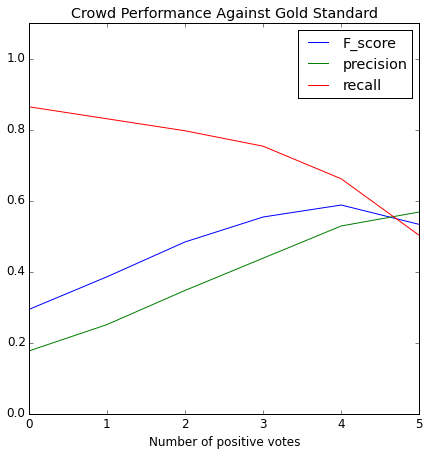

In [59]:
plot_results(official_res_vote, "Crowd Performance Against Gold Standard",
            "Number of positive votes", 12, (7, 7), 1)

---

### Results if redundant relations are removed

In [60]:
filtered_res = official_F_score("num_votes", gold_relations, final_res, True).sort("threshold")

In [61]:
filtered_res

,F_score,precision,recall,threshold
5,0.308386,0.189579,0.826087,0
0,0.396135,0.264090,0.792271,1
1,0.490625,0.362587,0.758454,2
3,0.564972,0.462963,0.724638,3
4,0.602679,0.560166,0.652174,4
2,0.539683,0.596491,0.492754,5


In [62]:
def pair_plot(df1, df2, title, xlabel, fontsize, figsize, linewidth, fname = None):
    matplotlib.rcParams.update({"font.size": fontsize})

    ax = df1.plot(x = "threshold", figsize = figsize,
                  title = title, ylim = (0, 1.05), linewidth = linewidth)

    ax = df2.plot(ax = ax, x = "threshold", linestyle = "--", linewidth = linewidth)
    ax.set_xlabel(xlabel)

    if fname is not None:
        plt.savefig(fname, bbox_inches = "tight")

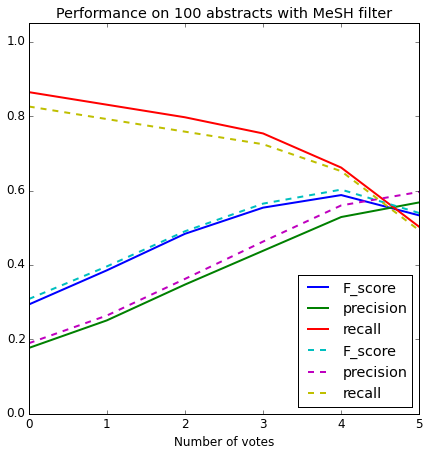

In [63]:
pair_plot(official_res_vote, filtered_res, "Performance on 100 abstracts with MeSH filter",
          "Number of votes", 12, (7, 7), 2)

## Performance with NER step excluded

Due to the NER step, some concept annotations will be missed or mismapped. When this happens, any relation which uses these concepts will automatically be counted as false positives or false negatives. To look at crowd performance on the relation extraction task only, we need to remove these relations.

However this seems like a more convoluted way of measuring performance instead of running the job over again, but using the gold standard annotations (which we were doing anyways). Hope the reviewers don't catch this..

In [64]:
def has_concept(paper, concept_id):
    concepts = set()
    for annot in paper.annotations:
        concepts |= set([iden.flat_repr for iden in annot.uid if iden.uid_type == "MESH"])
    
    return concept_id in concepts

In [65]:
final_res["chem_exists"] = final_res[["pmid", "chemical_id"]].apply(lambda row: has_concept(dev_gold[int(row["pmid"])], row["chemical_id"]), axis = 1)

final_res["dise_exists"] = final_res[["pmid", "disease_id"]].apply(lambda row: has_concept(dev_gold[int(row["pmid"])], row["disease_id"]), axis = 1)

In [66]:
final_res.head()

,chemical_id,disease_id,norm_conf_score,num_votes,pmid,rel_origin,chem_exists,dise_exists
0,MESH:D020117,MESH:D015746,0.203278,1,9669632,abstract_task,True,True
1,MESH:D020117,MESH:D005767,0.423201,2,9669632,abstract_task,True,True
2,MESH:D020117,MESH:D003248,0.212550,1,9669632,sentence_task,True,True
3,MESH:D020117,MESH:D003967,0.377915,2,9669632,sentence_task,True,True
4,MESH:D020117,MESH:D010146,1.000000,5,9669632,sentence_task,True,True


In [67]:
final_res.query("~chem_exists or ~dise_exists")

,chemical_id,disease_id,norm_conf_score,num_votes,pmid,rel_origin,chem_exists,dise_exists
38,MESH:C535011,MESH:D007249,0.578724,3,15858223,abstract_task,False,True
42,MESH:C535011,MESH:D056486,0.000000,0,15858223,abstract_task,False,True
54,MESH:C535011,MESH:D005234,0.387268,2,15858223,sentence_task,False,True
56,MESH:C535011,MESH:D009336,0.606375,3,15858223,sentence_task,False,True
65,MESH:C030299,MESH:D007153,0.000000,0,2004015,abstract_task,True,False
68,MESH:D015215,MESH:D007153,0.000000,0,2004015,sentence_task,True,False
85,MESH:D016572,MESH:D014456,0.179383,1,11063349,abstract_task,True,False
88,MESH:D020123,MESH:C565579,0.576151,3,11063349,abstract_task,True,False
92,MESH:D016559,MESH:D014456,0.000000,0,11063349,abstract_task,True,False
95,MESH:D003404,MESH:C565579,0.583801,3,11063349,abstract_task,True,False


In [68]:
final_res["chem_exists"].value_counts()

True     989
False     23
dtype: int64

In [69]:
final_res["dise_exists"].value_counts()

True     950
False     62
dtype: int64

In [70]:
final_res.query("~chem_exists or ~dise_exists").shape

(84, 8)

In [71]:
def filter_gold(gold_rels, dataframe):
    concepts = defaultdict(set)
    for pmid, group in dataframe.groupby("pmid"):
        concepts[pmid] |= set(group["chemical_id"]) | set(group["disease_id"])
        
    res = set()
    for pmid, chem, dise in gold_rels:
        if set([chem, dise]) <= concepts[pmid]:
            res.add((pmid, chem, dise))
            
    return res

In [72]:
indexable = final_res.query("chem_exists and dise_exists")
common_gold = filter_gold(gold_relations, indexable)

In [73]:
no_ner_res = official_F_score("num_votes", common_gold, indexable).sort("threshold")

In [74]:
no_ner_res

,F_score,precision,recall,threshold
5,0.323397,0.192888,1.000000,0
0,0.420538,0.269171,0.960894,1
1,0.528000,0.369955,0.921788,2
3,0.610568,0.469880,0.871508,3
4,0.647754,0.561475,0.765363,4
2,0.595989,0.611765,0.581006,5


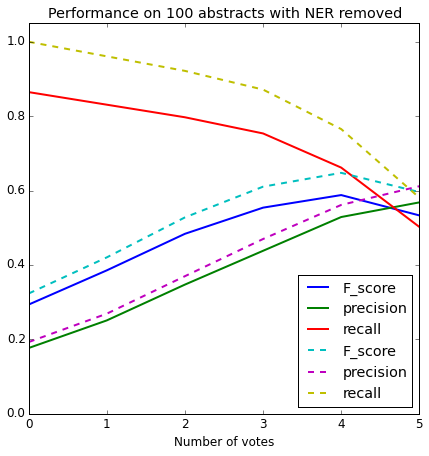

In [75]:
pair_plot(official_res_vote, no_ner_res, "Performance on 100 abstracts with NER removed",
          "Number of votes", 12, (7, 7), 2)

In [76]:
no_ner_filtered = official_F_score("num_votes", common_gold, indexable, True).sort("threshold")

In [77]:
no_ner_filtered

,F_score,precision,recall,threshold
5,0.337255,0.204518,0.960894,0
0,0.432503,0.282534,0.921788,1
1,0.534687,0.383495,0.882682,2
3,0.618557,0.490196,0.837989,3
4,0.661765,0.589520,0.754190,4
2,0.601770,0.637500,0.569832,5


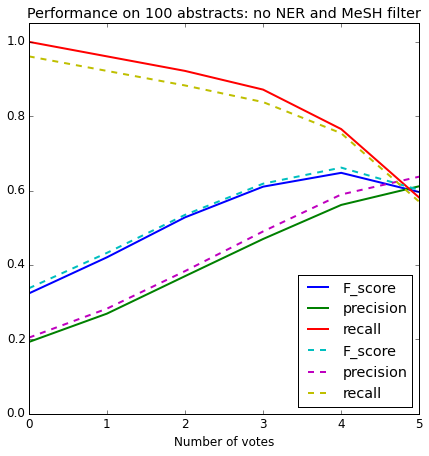

In [78]:
pair_plot(no_ner_res, no_ner_filtered, "Performance on 100 abstracts: no NER and MeSH filter",
          "Number of votes", 12, (7, 7), 2)

## Error analysis

PMID | Chemical | disease | Origin | Discussion
--- | ---
3088349 | D016627 | D001927 | CID | Id mismatch. Gold has no id for "substantia nigra lesion", whereas we mapped it to "D001927", "brain diseases". Not a mistake in the regex. Missing id in gold.
9270571 | D015632 | D010302 | CID | For "MPTP-induced parkinsonism", gold mapped "parkinsonism" to D020734 but we mapped it to D010300. Not a regex mistake. ID mismatch.
8267029 | D010396 | C538458 | CID | Gold used "glomerulonephritis" instead of "rapidly progressive glomerulonephritis" with "penicillamine". Term was not a disease according to the gold. ID mismatch.
10910842 | D011239 | D009135 | CID | Mismatch in IDs for "muscle dysfunction". We used "D009135" instead of D018908. ID mismatch.
8111719 | D007096 | D020258 | CID | "ifosfamide-induced neurotoxicity". Gold used hallucination instead of the more general neurotoxicity. Not a regex error. Hierarchy error.
18657397 | D010406 | D004827 | CID | "penicillin induced epileptiform activity". Gold used "penicillin G potassium" instead of "penicillin". ID mismatch
9041081 | D013256 | D009798 | CID | "steroid induced elevated intraocular pressure". Gold used "corticosteriod" instead of "steroid". Hierarchy mismatch.
20533999 | D008694 | D064420, D009461 | CID | "methamphetamine induced (toxicity and dopaminergic deficits)". Gold only used neurotoxicity, which is a more specific form of toxicity. Hierarchy mismatch
1595783 | D000638 | D008171 | CID | "amiodarone-induced pulmonary toxicity" Gold does not include this relation, preferring hypersensitivity pneumonitis instead.
12452237 | D013390 | D063806 | CID | "succinylcholine induced myalgia". Gold contains "succinylcholine induced postoperative myalgia", but not regular "myalgia" (different identifiers).
16192988 | D008694 | D006948 | CID | "meth-induced hyperactivity". This relation was never included in the gold, but the pattern was found correctly.
3708922 | D016572 | D064420 | CID | "CSA induced toxicity". Gold only contains "CSA induced nephrotoxicity". However, it seems like Gentamicin should also be related to nephrotoxicity since "Gentamicin increased CSA nephrotoxicity". NER never found "nephrotoxicity" in the same sentence as gentamicin (but annotated renal toxicity with the same ID), and therefore we missed this relation.






Error analysis: sentences in gold but crowd said no (<= 1 positive vote)

PMID | Chemical | Disease | Origin | Discussion
--- | ---
7710775 | D008315 | D002545 | sentence | "malondialdehyde and cerebral ischemia". IDs were successfully mapped. The text states that cerebral ischemia in a rat model was caused by clamping the carotid artery. They then sampled the blood for malondialdehyde and found that it increased in concentration starting 5 min after ischemia. The gold standard lists malondialdehyde as causing ischemia, whereas the abstract suggests that the relation is more of a correlation. Seems like gold is wrong here.. Crowd said 0/5 true, only saw the title.
20042557 | D015742 | D003693, D011183 | sentence | "propofol and delirium, postoperative delirium". We missed 2 gold relations. The gold is correct in stating that propofol leads to postoperative delirium when used in high concentrations. In the last sentence, where propofol and postoperative delirium is mentioned together, the sentence says using "light propofol sedation" decreases the prevalance of "postoperative delirium" compared with deep sedation (high propofol concentration). The crowd is not wrong here in saying that the sentence doesn't support a CID relation. The task formulation removed the larger context. Gold is right.
10840460 | D003520 | D010146 | sentence | "cyclophosphamide and painful syndromes". Crowd only saw the concluding sentence, and therefore had no information about what the "painful syndromes" referred to. If anything this is bad form on the gold's part, because the individual syndromes should have been annotated, and not "painful syndromes" in general.




Error analysis: sentences not in gold but crowd said yes (5/5 positive votes)

PMID | Chemical | Disease | Origin | conclusion | Discussion
--- | ---
982002 | D012293 | D051437 | sentence | hierarchy error | "rifampicin and renal failure". Gold only contained "acute renal failure". Hierarchy problem. Can be fixed using MeSH (high overlap)
1423339 | D011433 | D000544, D064420 | sentence | ner error | propranolol and Alzheimer, toxicity. Gold only contained "amnestic syndrome". Alzheimer is a NER error, since it should be "Alzheimer-like subacute dementia". The toxicity one is more vague, since the text says "propranolol toxicity".
1535072 | D012701 | D020018 | sentence | ner error | "serotonin and sexual side effects". This is a result of poor NER highlighting. Serotonin is a chemical, but it was always used as "serotonin reuptake blockers", which is a completely different class of drug. The gold suffered from this too, since it annotated "serotonin" as a chemical many times instead of "serotonin reuptake blockers". We have previously seen that crowd performs very poorly at distinguishing NER errors when they are told the highlighted concept is a chemical/disease. Not much we could have done here without doing extraction de novo.
1535072 | D015016 | D001008 | sentence | gold missing relation | "yohimbine and anxiety". Abstract says "Side effects of yohimbine included excessive sweating, increased anxiety, and a wound-up feeling in some patients." Seems like gold is missing some relations? NER also never picked up "excessive sweating" or "wound-up feeling".
1628552 | D002738 | D014786 | sentence | ner error | "chloroquine and deterioration of vision". NER error. Gold annotated deterioration of vision as D015354, and has the relation.
1628552 | D002738 | D006327 | sentence | gold missing relation? | "chloroquine and heart block". Correct ids, but relation missing from gold. Title says "Chloroquine related complete heart block with blindness: case report". Gold error?
2257294 | D014529 | D064420 | sentence | gold missing relation | "uridine and toxicity". Text says "Because of the clinical toxicities associated with chronic Urd administration". Seems like gold is wrong?
3088349 | D016627 | D009069 | sentence | crowd likely wrong | "6-OHDA and contralateral rotation". Ids match but gold is missing relation. Seems like this should have been yes_indirect instead of yes_direct.

